In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [24]:
import numpy as np
from tqdm import tqdm_notebook as tqdm
from scipy.spatial import distance
import pickle
import json
import h5py
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
%matplotlib inline

from jupyterthemes import jtplot
jtplot.style(theme='grade3')

def load_file(path, name):
    import importlib.util
    spec = importlib.util.spec_from_file_location(name, path)
    mod = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(mod)
    return mod

models = load_file("../../utils/models.py", "models")


cuda = torch.device('cuda')
frame_size = 10
# https://drive.google.com/open?id=1kTyu05ZmtP2MA33J5hWdX8OyUYEDW4iI
movie_ref = pickle.load(open('../../data/infos_pca128.pytorch', 'rb'))
# on my system os error often pops up
# try to open the file explorer and copy paste the path again 
# https://drive.google.com/open?id=1pPf-7AmUVceVfgfmKEJ6ireEDKEJHw-7
f = h5py.File("../../data/static_ml20m.hdf5", "r")
# https://drive.google.com/open?id=1xjVI4uVQGsQ7tjOJ3594ZXmAEC_6yX0e
meta = json.load(open('../../data/metadata.json'))

In [25]:
ddpg = models.Actor(1290, 128, 256).to(cuda)
td3 = models.Actor(1290, 128, 256).to(cuda)
bcq_actor = models.BCQ_Actor(1290, 128, 256).to(cuda)
bcq_vae = models.BCQ_VAE(1290, 128, 512).to(cuda)
ddpg.load_state_dict(torch.load('../../models/DDPG/ddpg_policy.pt'))
td3.load_state_dict(torch.load('../../models/TD3/td3_policy_1.pt'))
bcq_actor.load_state_dict(torch.load('../../models/BCQ/bcq_policy.pt'))
bcq_vae.load_state_dict(torch.load('../../models/BCQ/bcq_vae.pt'))

batch_size = 5000
n_batches = (f['done'].shape[0] // batch_size) - 1

In [26]:
test_batch = [f[key][n_batches*batch_size:(n_batches+1)*batch_size] for key in
                 ['movies', 'ratings', 'done']]


movies, ratings, done = test_batch
movies, ratings, done = [torch.tensor(i.astype('float32')) for i in [movies, ratings, done]]
movies_tensor = torch.stack([torch.stack([movie_ref[int(i)] for i in ts]) for ts in movies])
    
state = torch.cat([movies_tensor[:, :-1, :].view(batch_size, -1),
                       ratings[:, :-1]], 1).to(cuda)

In [27]:
def rank(gen_action, metric):
    scores = []
    for i in movie_ref.keys():
        scores.append([i, metric(movie_ref[i], gen_action)])
    scores = list(sorted(scores, key = lambda x: x[1]))
    scores = scores[:10]
    ids = [i[0] for i in scores]
    dist = [i[1] for i in scores]

    return ids, dist

In [28]:
import faiss
# test indexes
indexL2 = faiss.IndexFlatL2(128)
indexIP = faiss.IndexFlatIP(128)
indexCOS = faiss.IndexFlatIP(128)

mov_mat  = np.stack(movie_ref.values()).astype('float32')
indexL2.add(mov_mat)
indexIP.add(mov_mat)
indexCOS.add(normalize(mov_mat, axis=1, norm='l2'))


def query(index, action, k=20):
    D, I = index.search(action, k)
    return D, I

/home/dev/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  import sys


In [29]:
ddpg_action = ddpg(state)
ddpg_action = ddpg_action[np.random.randint(0, 5000, 50)].detach().cpu().numpy() 
td3_action = td3(state)
td3_action = td3_action[np.random.randint(0, 5000, 50)].detach().cpu().numpy() 
sampled_actions = bcq_vae.decode(state)
perturbed_actions= bcq_actor(state, sampled_actions)
bcq_action = perturbed_actions[np.random.randint(0, 5000, 50)].detach().cpu().numpy()

## Euclidean L2 Distance

In [30]:
def get_err_l2_dist(action, k=5):
    D, I = query(indexL2, action)
    D = D ** 0.5 # l2 -> euclidean
    mean = D.mean(axis=1).mean()
    std  = D.std(axis=1).mean()
    return mean, std

In [31]:
ddpg_mean, ddpg_std = get_err_l2_dist(ddpg_action, 10)
td3_mean, td3_std = get_err_l2_dist(td3_action, 10)
bcq_mean, bcq_std = get_err_l2_dist(bcq_action, 10)

labels = ['DDPG', 'TD3', 'BCQ']
x_pos = np.arange(len(labels))
CTEs = [ddpg_mean, td3_mean, bcq_mean]
error = [ddpg_std, td3_std, bcq_std]

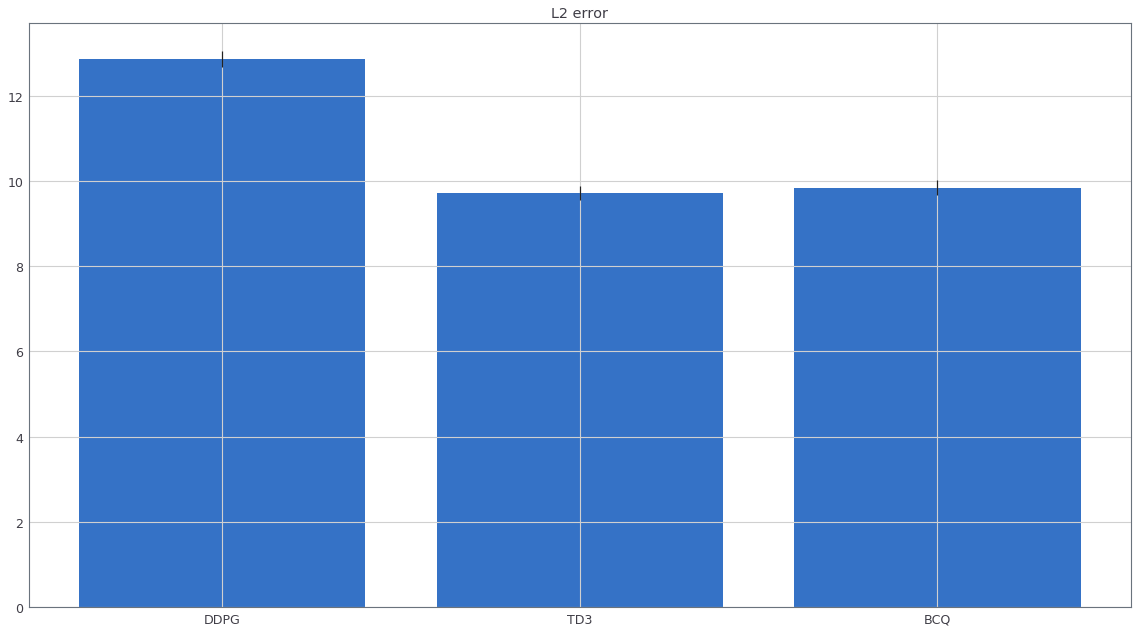

In [32]:
fig, ax = plt.subplots(figsize=(16, 9))
ax.bar(x_pos, CTEs,yerr=error,)
ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
ax.set_title('L2 error')
ax.yaxis.grid(True)

# Save the figure and show
plt.tight_layout()
plt.show()

## InnerProduct Distance

In [33]:
def get_err_ip_dist(action, k=5):
    D, I = query(indexIP, action)
    mean = D.mean(axis=1).mean()
    std  = D.std(axis=1).mean()
    return mean, std

In [34]:
ddpg_mean, ddpg_std = get_err_ip_dist(ddpg_action, 10)
td3_mean, td3_std = get_err_ip_dist(td3_action, 10)
bcq_mean, bcq_std = get_err_ip_dist(bcq_action, 10)

labels = ['DDPG', 'TD3', 'BCQ']
x_pos = np.arange(len(labels))
CTEs = [ddpg_mean, td3_mean, bcq_mean]
error = [ddpg_std, td3_std, bcq_std]

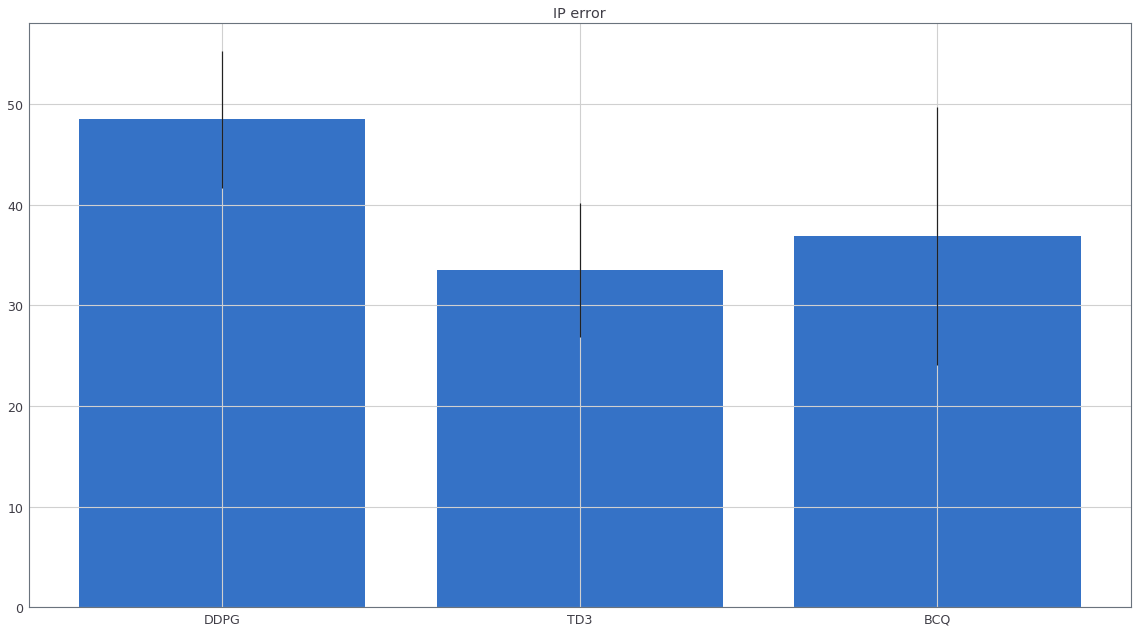

In [35]:
fig, ax = plt.subplots(figsize=(16, 9))
ax.bar(x_pos, CTEs,yerr=error,)
ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
ax.set_title('IP error')
ax.yaxis.grid(True)

# Save the figure and show
plt.tight_layout()
plt.show()

In [36]:
D, I = query(indexIP, bcq_action)

## Cosine Distance

In [41]:
def get_err_cos_dist(action, k=5):
    action = normalize(action, axis=1, norm='l2')
    D, I = query(indexCOS, action)
    mean = D.mean(axis=1).mean()
    std  = D.std(axis=1).mean()
    return mean, std

In [42]:
# normalization test
np.allclose(np.linalg.norm(normalize(ddpg_action, axis=1, norm='l2'), axis=1), 1)

True

In [43]:
ddpg_mean, ddpg_std = get_err_cos_dist(ddpg_action, 10)
td3_mean, td3_std = get_err_cos_dist(td3_action, 10)
bcq_mean, bcq_std = get_err_cos_dist(bcq_action, 10)

labels = ['DDPG', 'TD3', 'BCQ']
x_pos = np.arange(len(labels))
CTEs = [ddpg_mean, td3_mean, bcq_mean]
error = [ddpg_std, td3_std, bcq_std]

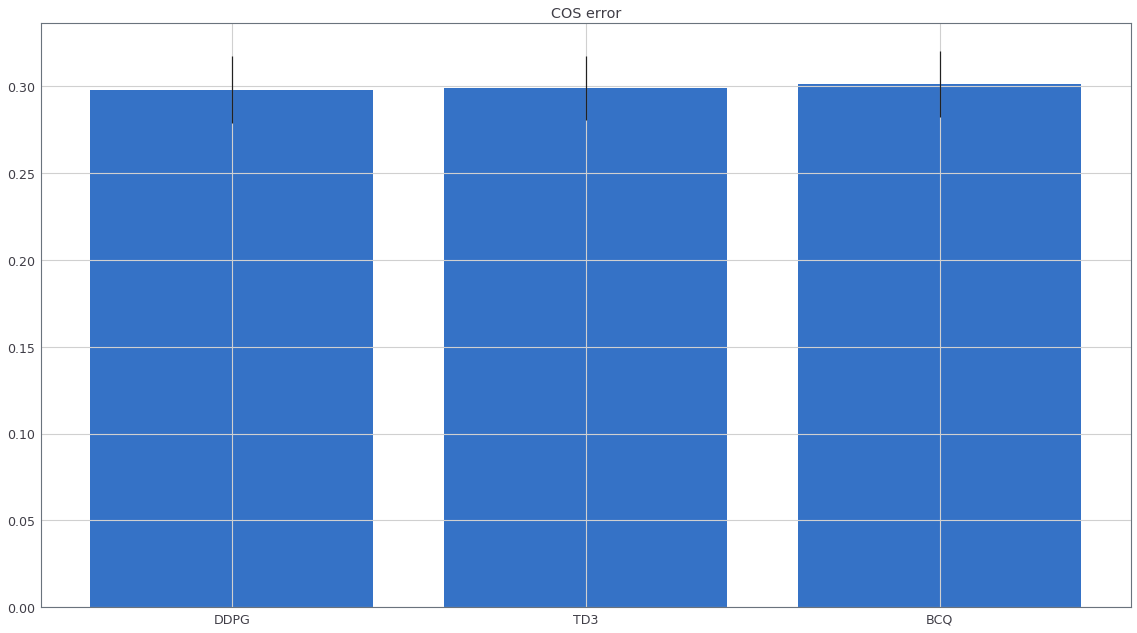

In [45]:
fig, ax = plt.subplots(figsize=(16, 9))
ax.bar(x_pos, CTEs,yerr=error,)
ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
ax.set_title('COS error')
ax.yaxis.grid(True)

# Save the figure and show
plt.tight_layout()
plt.show()